In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage,set_link_color_palette
from sklearn.feature_selection import SelectKBest,SelectFromModel,f_classif

# DataSet

In [2]:
df=pd.DataFrame(pd.read_csv('../top_Gads_updated.dat',header=None, comment="#",sep='\s+',
                            squeeze=True, names=["material","adsorbate","DF_lower","DF_upper","DF"]))

df=df[['material', 'adsorbate','DF']]
aminoacid=df["adsorbate"].unique()

n={}
for i in aminoacid:
    n[i]=list(df[df.adsorbate==i]['DF'])
X=pd.DataFrame(n)
aminoacids_label=list(df["adsorbate"].unique())
material_label=list(df["material"].unique())
X.index=material_label 

# Data Preparation

In [3]:
X.rename(columns={'C3H6': 'PRP','C4H6': 'BUT-2','C4H8': 'BUT-1'}, inplace=True)
X.columns.unique()

Index(['ALA', 'ARG', 'ASN', 'ASP', 'CHL', 'CYM', 'CYS', 'DGL', 'EST', 'ETA',
       'GAN', 'GLN', 'GLU', 'GLY', 'HID', 'HIE', 'HIP', 'ILE', 'LEU', 'LYS',
       'MET', 'PHE', 'PHO', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'PRP',
       'BUT-2', 'BUT-1'],
      dtype='object')

In [5]:
X.rename(index={'C_amorph-1':'C-AM-1', 'C_amorph-2':'C-AM-2', 'C_amorph-3':'C-AM-3',
                'CNT15-COO--10':'CNT-COO$^{-}$-high','CNT15-COO--3':'CNT-COO$^{-}$-low',
                'CNT15-COOH-30':'CNT-COOH-high', 'CNT15-COOH-3':'CNT-COOH-low', 
                'CNT15-NH2-14':'CNT-NH$_{2}$-high', 'CNT15-NH2-2':'CNT-NH$_{2}$-low',
                'CNT15-NH3+-4':'CNT-NH$_{3}^{+}$-high', 'CNT15-NH3+-2':'CNT-NH$^{+}_{3}$-low',
                'CNT15-OH-14':'CNT-OH-high', 'CNT15-OH-4':'CNT-OH-low',
                'CNT15':'CNT', 'Fe2O3-001O':'Fe$_{2}$O$_{3}$(001)',
                'graphene':'GR', 'bi-graphene':'bi-GR', 'tri-graphene':'tri-GR', 'grapheneoxide': 'GO', 'redgrapheneoxide': 'rGO',
                'SiO2-Q2': 'SiO$_{2}$-Q2', 'SiO2-Q4':'SiO$_{2}$-Q4',
                'TiO2-rut-110':'TiO$_{2}$-rut(110)' , 'TiO2-ana-101': 'TiO$_{2}$-ana(101)',
                'TiO2-rut-100':'TiO$_{2}$-rut(100)', 'TiO2-ana-100':'TiO$_{2}$-ana(100)', 
                'TiO2-ana-101-NB':'TiO$_{2}$-ana(101)-NB', 
                'ZnO-1010':'ZnO(10$\overline{1}}$0)', 'ZnO-1210':'ZnO(1$\overline{2}}$10)', 'ZnS-110':'ZnS(110)',
                'ZnS-110-coated':'ZnS(110)-coated'}, inplace=True)

# Biomolecules AgglomerativeClustering

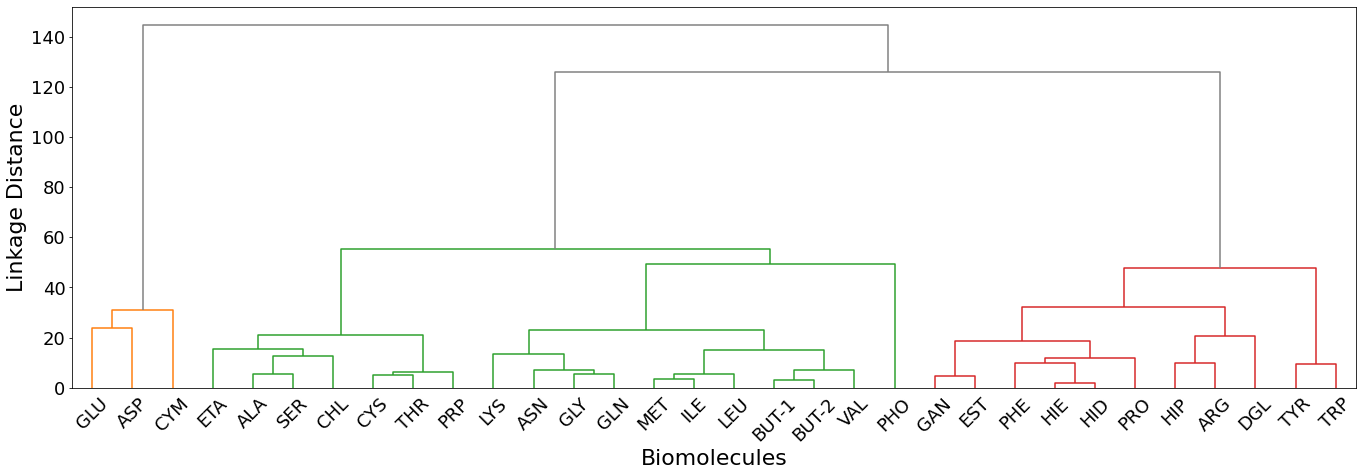

In [6]:
##plot
plt.figure(figsize=(23,7))
dendrogram(linkage(X.T,'ward',optimal_ordering = True),labels=X.columns.unique(), above_threshold_color='gray');
set_link_color_palette(['green','blue','red'])
plt.xlabel('Biomolecules',fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Linkage Distance',fontsize=22);
plt.savefig('cluster-aminoacids.png', format='png', dpi=1500, bbox_inches='tight')

#  Biomolecules Kmeans clustering and Distances to center of each cluster

In [9]:
##KMeans
X_new=X.T
model=KMeans(n_clusters=3, random_state=10)
kmeanpred=model.fit_predict(X_new)
Distance=model.transform(X_new) 
#print(Distance.shape)
X_new['D0']=Distance[:,0]
X_new['D1']=Distance[:,1]
X_new['D2']=Distance[:,2]
X_new['CLASS']=kmeanpred
X_new[X_new.CLASS==0].D0
X_new[X_new.CLASS==1].D1
X_new[X_new.CLASS==2].D2

/usr/local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ASP    12.152623
CYM    17.963725
GLU    17.320241
Name: D2, dtype: float64

# Nanomaterials AgglomerativeClustering (full data set) 

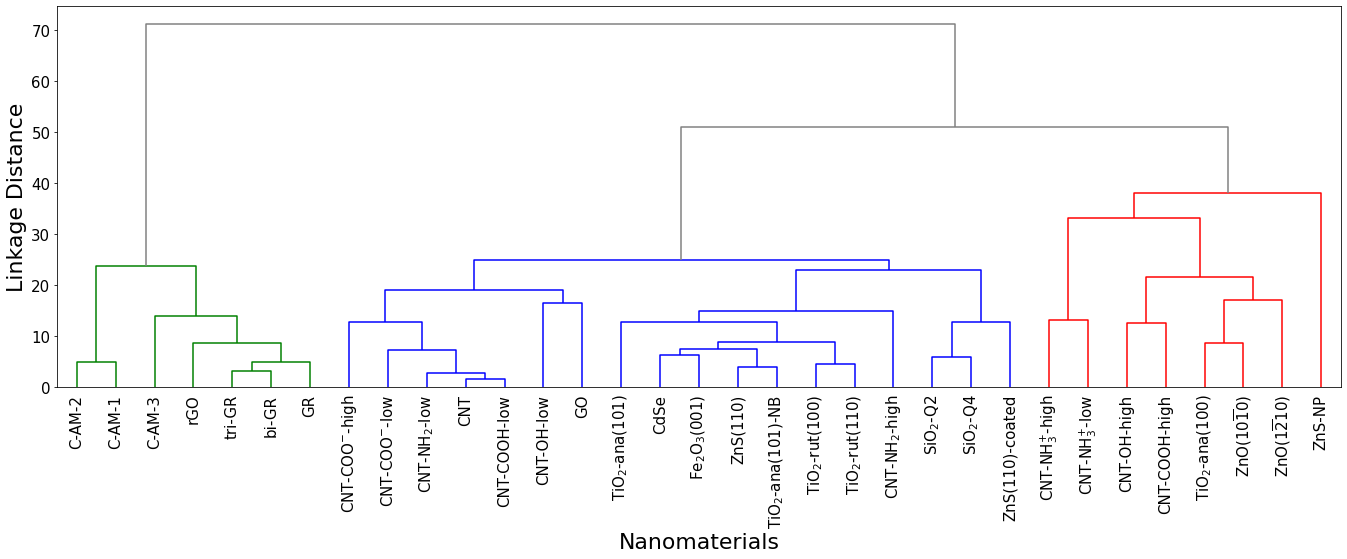

In [10]:
##plot
plt.figure(figsize=(23,7))
dendrogram(linkage(X,method='weighted',optimal_ordering = True),labels=X.index, 
           color_threshold=38,above_threshold_color='gray')
set_link_color_palette(['green','blue','red']) #
plt.xlabel('Nanomaterials',fontsize=22)
plt.ylabel('Linkage Distance',fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig('cluster-surfaces.png', format='png', dpi=1000, bbox_inches='tight')

# Nanomaterials AgglomerativeClustering (predicted data set) 

In [11]:
main=['ASP','VAL','PRO','ETA','PHO']
rest=[i for i in X.columns if i not in main]
def Mary_pred(i):
        Y=X[i]
        model= LinearRegression()
        model.fit(X[main],Y)
        ytest_pred=model.predict(X[main])
        return(ytest_pred)
X_new=X
for i in rest:
    X_new[i]= Mary_pred(i)    

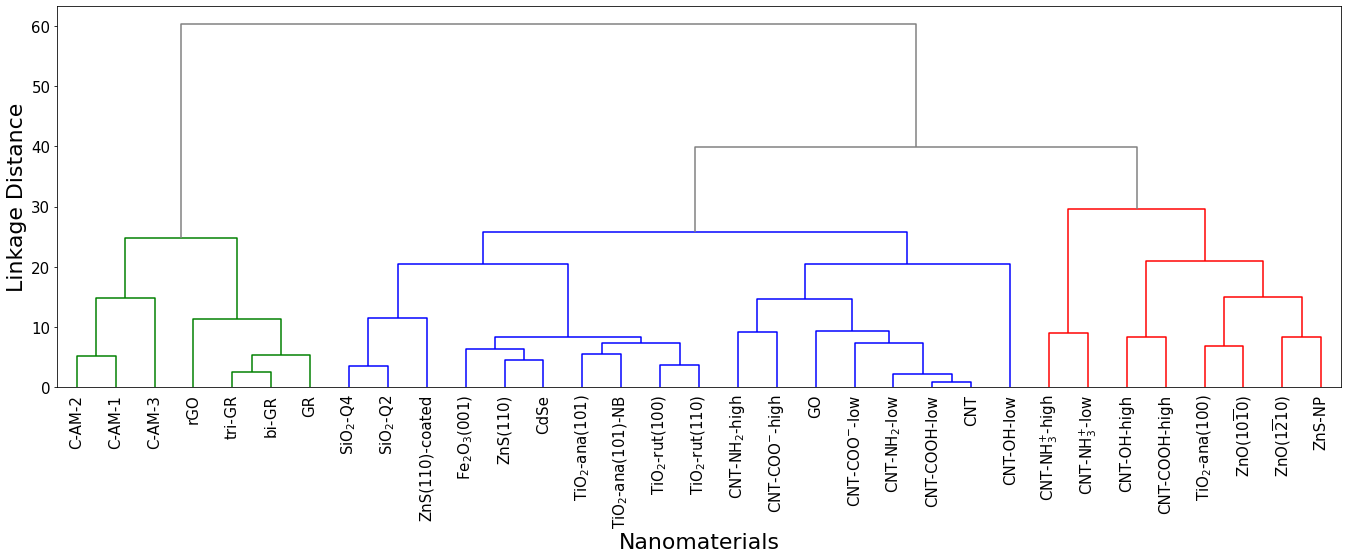

In [12]:
##plot
plt.figure(figsize=(23,7))
dendrogram(linkage(X_new,method='weighted',optimal_ordering = True),labels=X.index,
           color_threshold=35,above_threshold_color='gray')
set_link_color_palette(['green','blue','red'])
plt.xlabel('Nanomaterials',fontsize=22)
plt.ylabel('Linkage Distance',fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig('cluster-surfaces-prediction.png', format='png', dpi=1000, bbox_inches='tight')